# Pipeline to create the personalized Boolean Networks based on gene expression and Copy Number Variation Data 

In [ ]:
import pandas as pd
import os
import shutil

from functions.generate_utils.identification_patients.get_patients_sens_res import get_patients

from functions.generate_utils.identification_drug.drug_analysis import identify_drug

# from functions.generate_utils.create_generic_models.update_nodes_names import replace_node_names_in_file


from functions.generate_utils.create_generic_models.update_nodes_names import replace_node_names_in_file


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table, collect_group_data

from functions.analysis_utils.stats.stats_proba import compute_mannwhitneyu_test_means
from functions.analysis_utils.results_MaBoSS_visualization.boxplot_phenotype import create_boxplot


from functions.generate_models import generate_models_re, pre_process_re

from functions.analysis import downstream_analysis




from functions.validation_utils.validation_Breast import (
    correlate_boolean_predictions_with_gene_signatures
)




### Loading the datasets 

In [ ]:
# Loading the data (TCGA, cell model passport)

annotations_models = pd.read_csv('data/model_list_20250407.csv')
mutations_data = pd.read_csv('data/cellmodel_data/mutations_all_20250318.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')

montagud_original_data_df = (
    pd.read_csv('data/montagud_models/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])


nodes_montagud_synonyms = pd.read_csv('data/montagud_models/nodes_processed.csv')


rna_seq_data = pd.read_csv('data/cellmodel_data/rnaseq_merged_20250117/rnaseq_merged_20250117.csv')
cnv_data = pd.read_csv('data/cellmodel_data/cnv_summary_20250207.csv')

proteins_data = pd.read_csv('data/cellmodel_data/proteomics_all_20250211.csv')


models_depmap_annotation = pd.read_csv('data/cellmodel_data/model_list_20250423.csv')

onco_tsg_data = pd.read_csv('data/oncogenes_tsg.tsv', sep='\t')
                            
# mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')


In [ ]:
# identify_drug(drug_data, annotations_models, tissue_remove)

### Users parameters data 

In [ ]:
# User's data to choose

# example
type_model = 'genes_models'

drug_interest = 'AZD7762'

drug_targets = ['CHK1_2']


number_patients = 35 # in each group


# tissue_interest = 'HAEMATOPOIETIC AND LYMPHOID'



# Generic Boolean Network 
# Inputs
inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'SPOP', 'Carcinogen']



# Phenotypes
phenotype_interest = ["Proliferation","Invasion","DNA_Repair","Apoptosis"]


continuous_variable = 'genes'
discrete_variable = 'mutations'

folder_name = f'{discrete_variable}_{continuous_variable}'

In [ ]:

subdir = f"{'_'.join(drug_targets)}_target_block"
folder_generic_models = f"analysis/{drug_interest}/{folder_name}/{subdir}/models/generic/"
folder_models = f"analysis/{drug_interest}/{folder_name}/{subdir}/models"
patients_categ = ['resistant', 'sensitive', 'healthy']

for patient_categ in patients_categ:
    if not os.path.exists(f"analysis/{drug_interest}/{folder_name}/{subdir}/results/{patient_categ}"):
        os.makedirs(f"analysis/{drug_interest}/{folder_name}/{subdir}/results/{patient_categ}")

    if not os.path.exists(f"analysis/{drug_interest}/{folder_name}/{subdir}/models/{patient_categ}"):
        os.makedirs(f"analysis/{drug_interest}/{folder_name}/{subdir}/models/{patient_categ}")

dest_dir = f"analysis/{drug_interest}/{folder_name}/{subdir}/models/generic"
os.makedirs(dest_dir, exist_ok=True)



shutil.copy('data/montagud_models/Montagud2022_Prostate_Cancer.bnd', dest_dir)
shutil.copy('data/montagud_models/Montagud2022_Prostate_Cancer.cfg', dest_dir) 

### Pre-processing the data (genes, proteins, cnv)

In [ ]:
top_resistant_ids, top_sensitive_ids, top_healthy_ids, montagud_node_model, rna_seq_data_models_filtered, cnv_data_filtered, df_melted_protein, mutations_data_filtered = pre_process_re(
    montagud_original_data_df,
    nodes_montagud_synonyms,
    rna_seq_data,
    cnv_data,
    mutations_data,
    number_patients,
    drug_data,
    annotations_models,
    drug_interest,
    proteins_data,
    type_model,
    onco_tsg_data,
    tissue_interest=None,
    tissue_remove=None,
)



os.makedirs(f"analysis/{drug_interest}/{folder_name}/{subdir}/data_filtered", exist_ok=True)
rna_seq_data_models_filtered.to_csv(f"analysis/{drug_interest}/{folder_name}/{subdir}/data_filtered/rna_seq_data_filtered.csv")
cnv_data_filtered.to_csv(f"analysis/{drug_interest}/{folder_name}/{subdir}/data_filtered/cnv_data_filtered.csv")



In [ ]:
generate_models_re(
    discrete_variable,
    folder_generic_models,
    folder_models,
    top_resistant_ids,
    top_sensitive_ids,
    top_healthy_ids,
    drug_interest,
    drug_targets,
    phenotype_interest,
    rna_seq_data_models_filtered,
    montagud_node_model,
    cnv_data_filtered,
    mutations_data_filtered,
    type_model,
    df_melted_protein,
    amplif_factor = 100,
    intervention_gene=None,
    genetic_intervention='KO',
)

In [ ]:
# check no intersection between the two groups
intersection = set(top_resistant_ids) & set(top_sensitive_ids) & set(top_healthy_ids)
print(intersection)

### All pipeline (create personalized networks and compute attractors distribution)

In [ ]:
# Loading the data (TCGA, cell model passport)

import pandas as pd
import os
import shutil


annotations_models = pd.read_csv('data/model_list_20250407.csv')
mutations_data = pd.read_csv('data/cellmodel_data/mutations_all_20250318.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')
montagud_original_data_df = (
    pd.read_csv('data/montagud_models/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
nodes_montagud_synonyms = pd.read_csv('data/montagud_models/nodes_processed.csv')
rna_seq_data = pd.read_csv('data/cellmodel_data/rnaseq_merged_20250117/rnaseq_merged_20250117.csv')
cnv_data = pd.read_csv('data/cellmodel_data/cnv_summary_20250207.csv')
proteins_data = pd.read_csv('data/cellmodel_data/proteomics_all_20250211.csv')
onco_tsg_data = pd.read_csv('data/oncogenes_tsg.tsv', sep='\t')
                            

In [ ]:
rna_seq_data_filt_test = pd.read_csv('analysis/Pictilisib/mutations_genes/PI3K_target_distribution_normalization/data_filtered/rna_seq_data_filtered.csv')

# Remove duplicates by aggregating (e.g., mean)

rna_normalized_filt = rna_seq_data_filt_test[['model_id', 'gene_symbol', 'rsem_tpm']]

rna_normalized_filt = rna_normalized_filt.rename(columns={'gene_symbol': 'Hugo_Symbol'})

rna_normalized_filt = rna_normalized_filt.groupby(['model_id', 'Hugo_Symbol'], as_index=False).agg({'rsem_tpm': 'mean'})

rna_normalized_filt = rna_normalized_filt.pivot(
index='Hugo_Symbol',      # Genes as index
columns='model_id',       # Patients as columns
values='rsem_tpm'         # Expression values
)

rna_normalized_filt.index.name = 'Hugo_Symbol'
rna_normalized_filt.columns.name = None

/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/identification_patients/get_patients_sens_res.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models_filtered.rename(


 Duplicated MTOR: mTORC1 (82 rows) + mTORC2 (82 rows)
 Duplicated MYC: MYC (82 rows) + MYC_MAX (82 rows)
 Duplicated PIK3CA: PI3K (82 rows) + PIP3 (82 rows)
 Duplicated LDHA: LDHA (82 rows) + Lactic_acid (82 rows)
 Duplicated ERG: AR_ERG (82 rows) + ERG (82 rows)
All .cfg and .bnd files created for sensitive, resistant and healthy patients.
Modified and saved: analysis/AZD7762/mutations_genes/CHK1_2_target_distribution_normalization/models/resistant/pers_models/SIDM00194_AZD7762.cfg
Modified and saved: analysis/AZD7762/mutations_genes/CHK1_2_target_distribution_normalization/models/resistant/pers_models/SIDM00892_AZD7762.cfg
Modified and saved: analysis/AZD7762/mutations_genes/CHK1_2_target_distribution_normalization/models/resistant/pers_models/SIDM00547_AZD7762.cfg
Modified and saved: analysis/AZD7762/mutations_genes/CHK1_2_target_distribution_normalization/models/resistant/pers_models/SIDM00735_AZD7762.cfg
Modified and saved: analysis/AZD7762/mutations_genes/CHK1_2_target_distributi

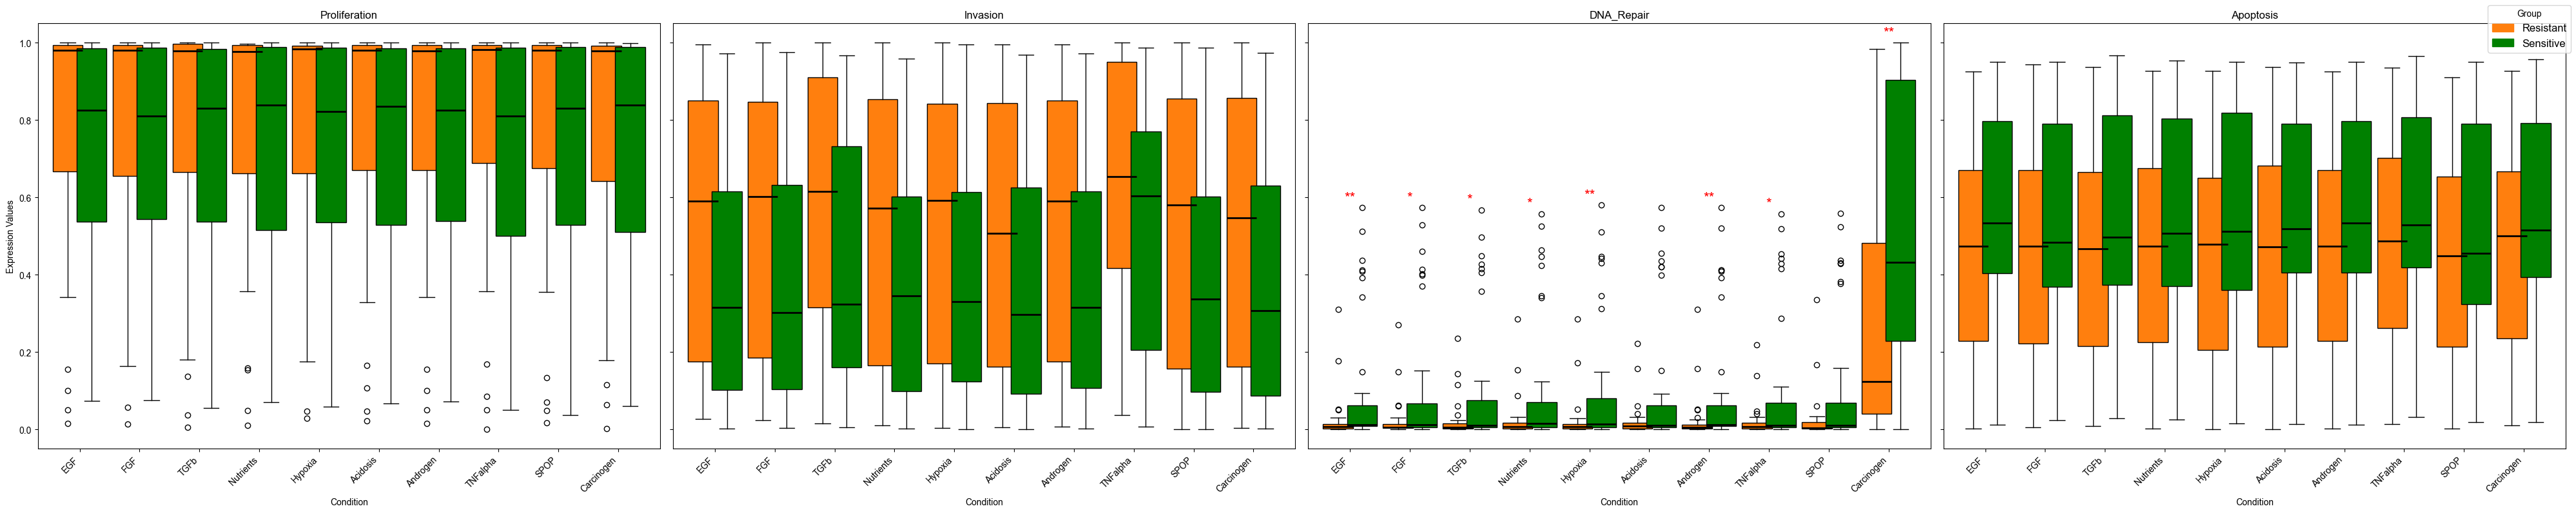

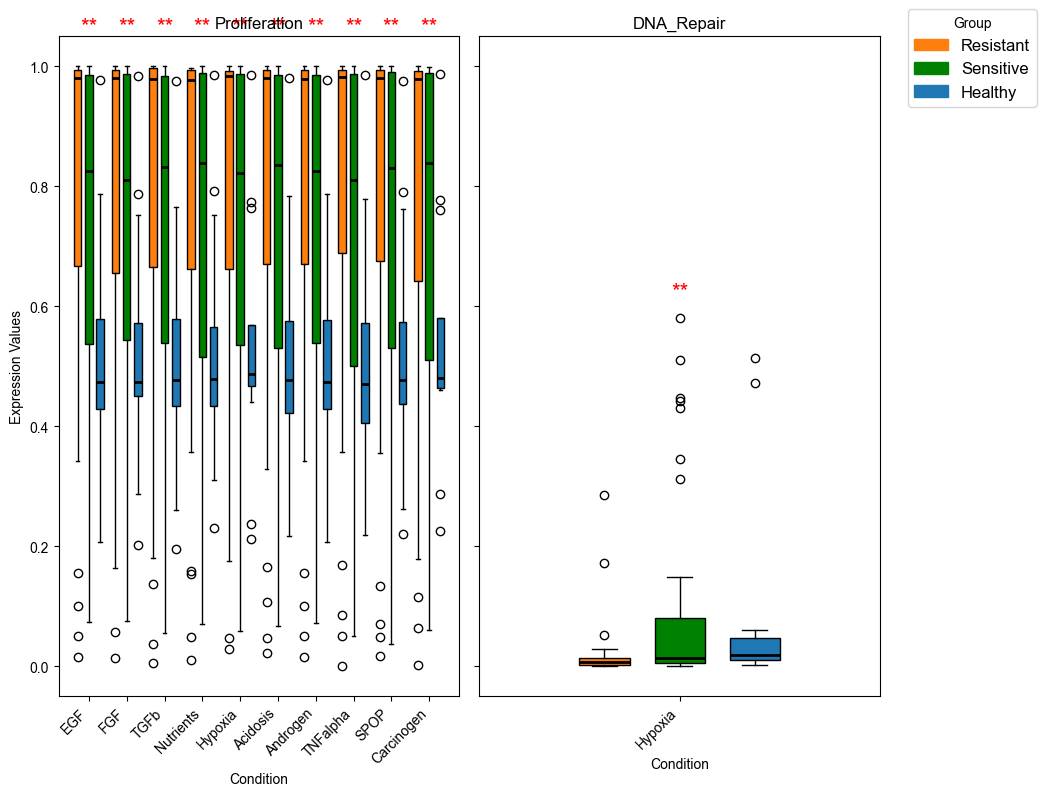

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/MaBoSS_simulation/maboss_phenotype_patient.py:262: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patient_mean.loc[condition][phenotype] = mean
/Users/romane/repos/icr/Attr

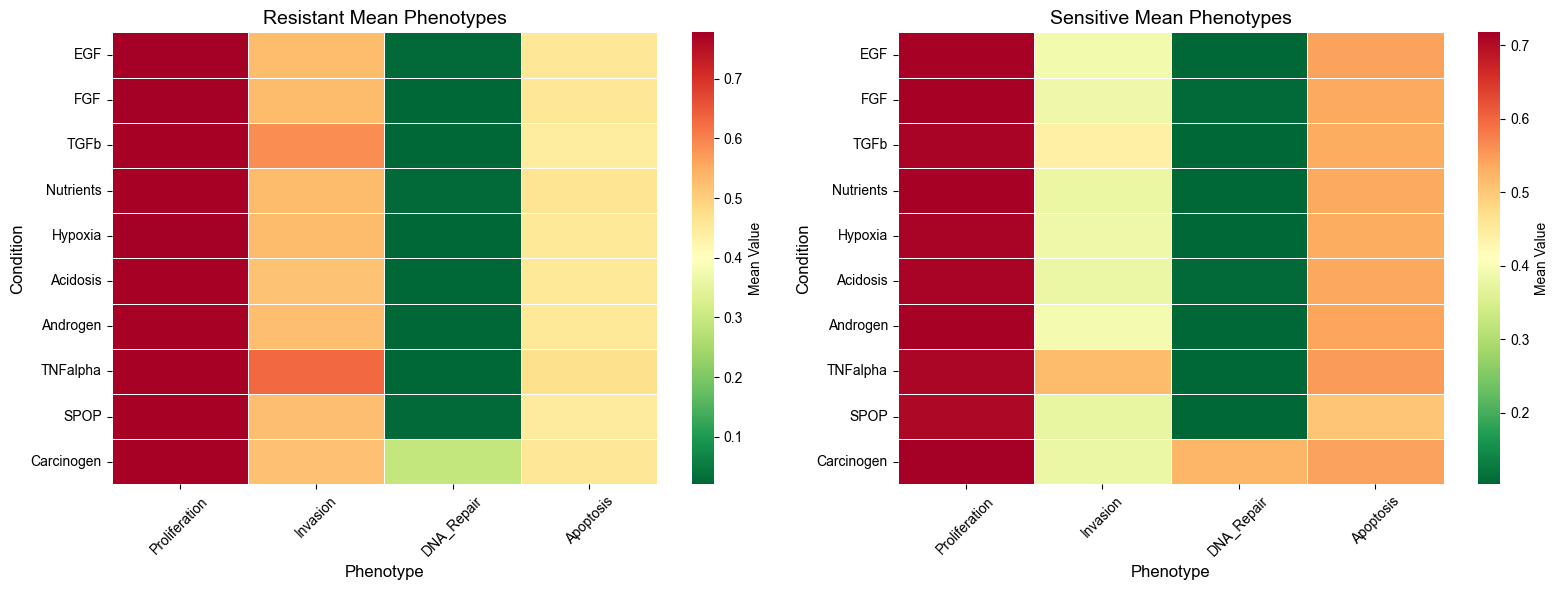

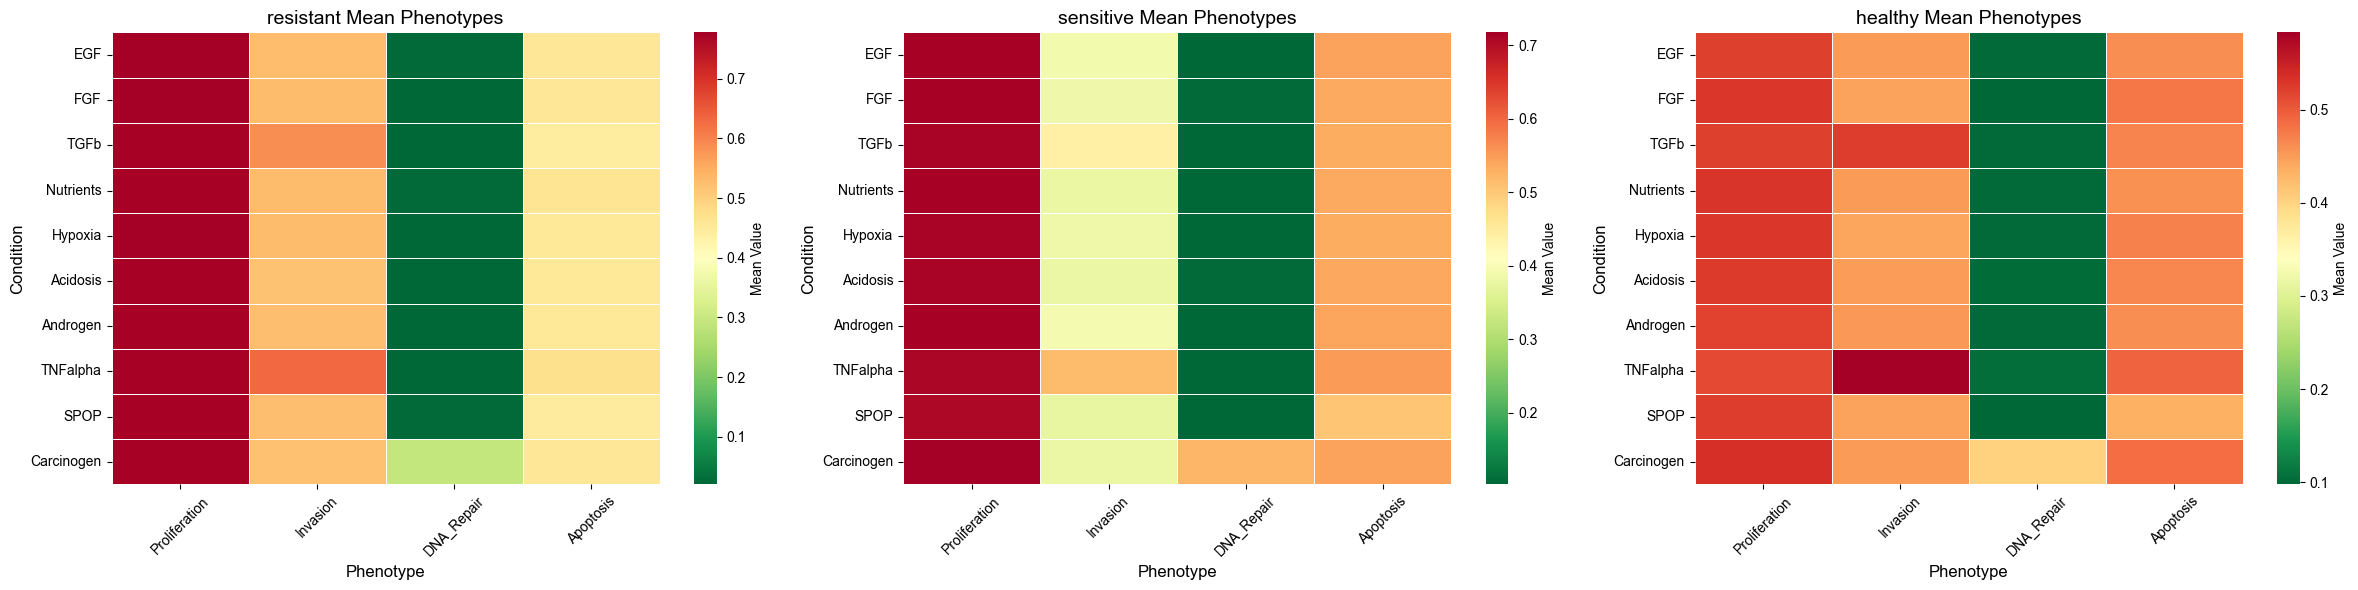

['SIDM00758', 'SIDM00770', 'SIDM00217', 'SIDM00772', 'SIDM01242', 'SIDM00835', 'SIDM00574', 'SIDM00415', 'SIDM00920', 'SIDM00882', 'SIDM00881', 'SIDM00700', 'SIDM00879', 'SIDM00892', 'SIDM00448', 'SIDM01186', 'SIDM00097', 'SIDM01175', 'SIDM00653', 'SIDM00282', 'SIDM00719', 'SIDM01002', 'SIDM00293', 'SIDM00735', 'SIDM00292', 'SIDM00319', 'SIDM00737', 'SIDM00194', 'SIDM00547', 'SIDM00235', 'SIDM00963', 'SIDM00340', 'SIDM00633', 'SIDM00971', 'SIDM01107', 'SIDM00604', 'SIDM01095', 'SIDM00412', 'SIDM00406', 'SIDM00567', 'SIDM00407', 'SIDM01057', 'SIDM00388', 'SIDM00798', 'SIDM00428', 'SIDM00561', 'SIDM00211', 'SIDM00576', 'SIDM00459', 'SIDM01009', 'SIDM00277', 'SIDM01023', 'SIDM00264', 'SIDM00449', 'SIDM00875', 'SIDM01015', 'SIDM01003', 'SIDM01017', 'SIDM00657', 'SIDM01005', 'SIDM01010', 'SIDM01038', 'SIDM01076', 'SIDM01248', 'SIDM00544', 'SIDM00949', 'SIDM00421', 'SIDM00233', 'SIDM00740', 'SIDM00437']
Saved final phenotype table to: analysis/AZD7762/mutations_genes/CHK1_2_target_distributi

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/gene_enrichment/genes_signature.py:131: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_normal_group_1 = stats.shapiro(group_resistant_phenotype)
/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/gene_enrichment/genes_signature.py:141: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_value = stats.mannwhitneyu(
/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/gene_enrichment/genes_signature.py:131: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_normal_group_1 = stats.shapiro(group_resistant_phenotype)
/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_util

Completed AZD7762 with distribution_normalization normalization successfully!
Pipeline completed!


In [3]:
# # ALL PIPELINE 

from functions.generate_models import generate_models_re, pre_process_re

from functions.analysis import downstream_analysis

from functions.validation_utils.validation_Breast import (
    correlate_boolean_predictions_with_gene_signatures
)



inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'SPOP', 'Carcinogen']
phenotype_interest = ["Proliferation","Invasion","DNA_Repair","Apoptosis"]



drugs_dict = {'AZD7762': ['CHK1_2']}

type_models = ['genes_models']

continuous_variable = 'genes'
discrete_variable = 'mutations'

folder_name = f'{discrete_variable}_{continuous_variable}'
number_patients = 35



# normalization_techniques = ['sigmoid', 'min-max','log_transf','global_minmax', 'global_log']



normalization_techniques = ['distribution_normalization']

for drug in drugs_dict:
    drug_targets = drugs_dict[drug]

    for type_model in type_models:
        for norm_technique in normalization_techniques:
            subdir = f"{'_'.join(drug_targets)}_target_{norm_technique}"
            folder_generic_models = f"analysis/{drug}/{folder_name}/{subdir}/models/generic/"
            folder_models = f"analysis/{drug}/{folder_name}/{subdir}/models"
            folder_results = f"analysis/{drug}/{folder_name}/{subdir}"


            patients_categ = ['resistant', 'sensitive', 'healthy']
            

            for patient_categ in patients_categ:
                os.makedirs(f"analysis/{drug}/{folder_name}/{subdir}/results/{patient_categ}", exist_ok=True)
                os.makedirs(f"analysis/{drug}/{folder_name}/{subdir}/models/{patient_categ}", exist_ok=True)

            dest_dir = f"analysis/{drug}/{folder_name}/{subdir}/models/generic"

            os.makedirs(dest_dir, exist_ok=True)

            # Copy the files
            shutil.copy('data/montagud_models/Montagud2022_Prostate_Cancer.bnd', dest_dir)
            shutil.copy('data/montagud_models/Montagud2022_Prostate_Cancer.cfg', dest_dir)


            top_resistant_ids, top_sensitive_ids, top_healthy_ids, montagud_node_model, all_montagud_nodes, rna_seq_data_models_filtered, cnv_data_filtered, df_melted_protein, mutations_data_filtered = pre_process_re(
            montagud_original_data_df.copy(),
            nodes_montagud_synonyms,
            rna_seq_data.copy(),
            cnv_data.copy(),
            mutations_data.copy(),
            number_patients,
            drug_data.copy(),
            annotations_models.copy(),
            drug,
            proteins_data.copy(),
            type_model,
            onco_tsg_data,
            tissue_interest=None,
            tissue_remove=None,
        )
            
            patients_ids = top_resistant_ids + top_sensitive_ids + top_healthy_ids


            os.makedirs(f"analysis/{drug}/{folder_name}/{subdir}/data_filtered", exist_ok=True)
            rna_seq_data_models_filtered.to_csv(f"analysis/{drug}/{folder_name}/{subdir}/data_filtered/rna_seq_data_filtered.csv")
            cnv_data_filtered.to_csv(f"analysis/{drug}/{folder_name}/{subdir}/data_filtered/cnv_data_filtered.csv")

            # Convert list to DataFrame then save
            all_montagud_nodes_df = pd.DataFrame(all_montagud_nodes, columns=['gene_symbol'])
            all_montagud_nodes_df.to_csv(f"analysis/{drug}/{folder_name}/{subdir}/data_filtered/all_montagud_nodes.csv", index=False)


            generate_models_re(
            norm_technique,
            discrete_variable,
            continuous_variable,
            folder_generic_models,
            folder_models,
            top_resistant_ids,
            top_sensitive_ids,
            top_healthy_ids,
            drug,
            drug_targets,
            phenotype_interest,
            rna_seq_data_models_filtered,
            montagud_node_model,
            cnv_data_filtered,
            mutations_data_filtered,
            type_model,
            df_melted_protein,
            100, # amplif_factor
            None,  # intervention_gene
            'KO', # genetic_intervention
        )

            downstream_analysis(folder_name, subdir,folder_results,folder_models, drug, top_resistant_ids, top_sensitive_ids, top_healthy_ids, patients_categ, inputs_list, phenotype_interest, annotations_models, list_active_inputs = None)


            proba_phenotype = pd.read_csv(f'analysis/{drug}/{folder_name}/{subdir}/results/sensitive_resistant_results/patients_phenot_table.csv', index_col=0)

            results_corr_invasion_df, correlation_invasion_data = correlate_boolean_predictions_with_gene_signatures(proba_phenotype, 'Epithelial Mesenchymal Transition', 'Invasion', rna_seq_data, patients_ids)
            results_corr_prolif_df, correlation_prolif_data = correlate_boolean_predictions_with_gene_signatures(proba_phenotype, 'G2-M Checkpoint', 'Proliferation', rna_seq_data, patients_ids)
            results_corr_apoptosis_df, correlation_prolif_data = correlate_boolean_predictions_with_gene_signatures(proba_phenotype, 'Apoptosis', 'Apoptosis', rna_seq_data, patients_ids)


            results_corr_invasion_df.to_csv(f'analysis/{drug}/{folder_name}/{subdir}/results/output/results_corr_invasion_df.csv')
            results_corr_prolif_df.to_csv(f'analysis/{drug}/{folder_name}/{subdir}/results/output/results_corr_prolif_df.csv')
            results_corr_apoptosis_df.to_csv(f'analysis/{drug}/{folder_name}/{subdir}/results/output/results_corr_apoptosis_df.csv')


            print(f"Completed {drug} with {norm_technique} normalization successfully!")

print("Pipeline completed!")

In [ ]:

# # Pre process data and saved them in the data filtered folder
# drugs_dict = {'Refametinib': ['MEK1', 'MEK2'], 'Pictilisib': ['PI3K'], 'AZD7762': ['CHK1', 'CHK2']}
# type_models = ['proteins_models', 'genes_models', 'genes_proteins_models']